In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/air-quality-data-in-india/stations.csv
/kaggle/input/air-quality-data-in-india/station_hour.csv
/kaggle/input/air-quality-data-in-india/city_day.csv
/kaggle/input/air-quality-data-in-india/city_hour.csv
/kaggle/input/air-quality-data-in-india/station_day.csv


In [2]:
import kagglehub
from google.colab import files

# Download latest version
path = kagglehub.dataset_download("rohanrao/air-quality-data-in-india")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/air-quality-data-in-india


In [3]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.5 MB/s eta 0:00:00


In [4]:
# Library imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings('ignore')

# Configure plot settings
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 6)

2025-06-09 21:55:04.299267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749506104.488889      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749506104.542071      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


First 5 entries:
                 PM2.5
Datetime              
2015-01-01  313.223043
2015-01-02  186.178333
2015-01-03   87.176667
2015-01-04  151.840000
2015-01-05  146.598333

Statistical description:
             PM2.5
count  2007.000000
mean    117.196179
std      82.912990
min      10.243333
25%      57.094792
50%      94.623750
75%     153.030000
max     685.364167

Number of missing values: PM2.5    0
dtype: int64


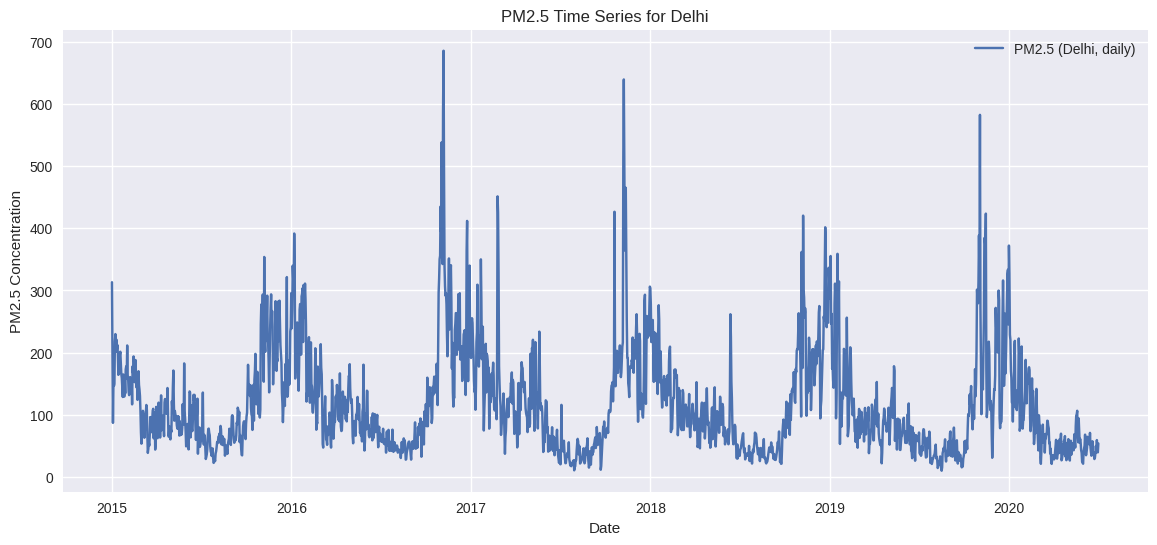

In [5]:
# Data loading and preprocessing
def load_and_preprocess_data():
    # Load data
    data = pd.read_csv('/kaggle/input/air-quality-data-in-india/city_hour.csv', 
                      parse_dates=['Datetime'], 
                      index_col='Datetime')
    
    # Select data for Delhi and PM2.5
    city_data = data[data['City'] == 'Delhi'][['PM2.5']].dropna()
    
    # Convert to daily data
    daily_data = city_data.resample('D').mean().dropna()
    
    return daily_data

# Call data loading function
ts_data = load_and_preprocess_data()

# Data inspection
print("First 5 entries:")
print(ts_data.head())
print("\nStatistical description:")
print(ts_data.describe())
print("\nNumber of missing values:", ts_data.isna().sum())

# Time series visualization
plt.figure(figsize=(14, 6))
plt.plot(ts_data, label='PM2.5 (Delhi, daily)')
plt.title('PM2.5 Time Series for Delhi')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid(True)
plt.show()


Data size before cleaning: 2007
Data size after cleaning: 2007
Missing values after cleaning: PM2.5    0
dtype: int64


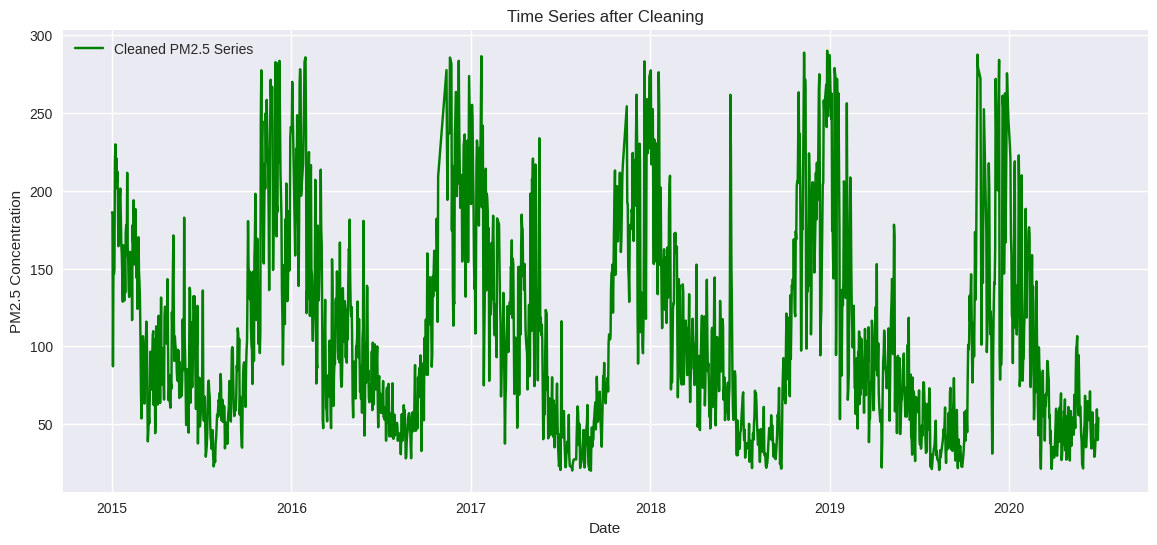

In [6]:
# Data cleaning and anomaly removal
def clean_data(data):
    # Anomaly detection
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    anomalies = iso_forest.fit_predict(data.values.reshape(-1, 1))
    
    # Remove anomalies
    cleaned_data = data[anomalies == 1]
    
    # Fill missing values
    cleaned_data = cleaned_data.reindex(data.index)
    cleaned_data = cleaned_data.interpolate(method='time').fillna(method='ffill').fillna(method='bfill')
    
    return cleaned_data

# Clean the data
cleaned_ts = clean_data(ts_data)

# Verify cleaning results
print("\nData size before cleaning:", len(ts_data))
print("Data size after cleaning:", len(cleaned_ts))
print("Missing values after cleaning:", cleaned_ts.isna().sum())

# Visualize cleaned data
plt.figure(figsize=(14, 6))
plt.plot(cleaned_ts, label='Cleaned PM2.5 Series', color='green')
plt.title('Time Series after Cleaning')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid(True)
plt.show()


Augmented Dickey-Fuller Test Results:
p-value: 0.0012
Series is stationary


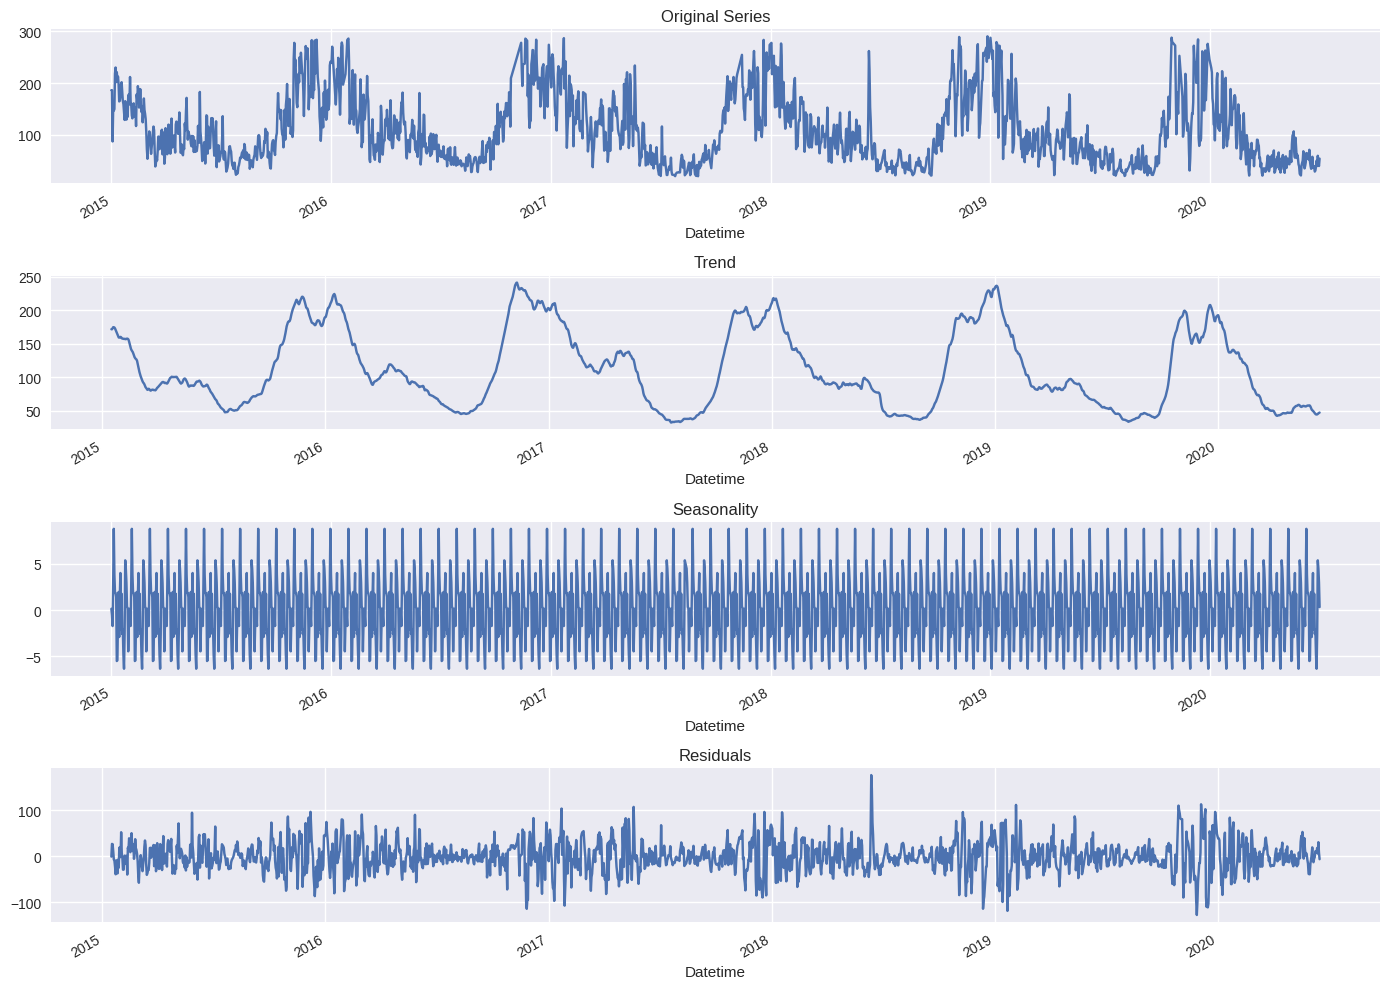

In [7]:
# Time series analysis
def analyze_time_series(data):
    # Stationarity test
    result = adfuller(data)
    print("\nAugmented Dickey-Fuller Test Results:")
    print(f"p-value: {result[1]:.4f}")
    if result[1] > 0.05:
        print("Series is non-stationary - differencing is required")
    else:
        print("Series is stationary")
    
    # Series decomposition
    decomposition = seasonal_decompose(data, model='additive', period=30)
    
    # Visualize decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10))
    decomposition.observed.plot(ax=ax1, title='Original Series')
    decomposition.trend.plot(ax=ax2, title='Trend')
    decomposition.seasonal.plot(ax=ax3, title='Seasonality')
    decomposition.resid.plot(ax=ax4, title='Residuals')
    plt.tight_layout()
    plt.show()

# Perform analysis
analyze_time_series(cleaned_ts['PM2.5'])


Training set size: 1605
Test set size: 402


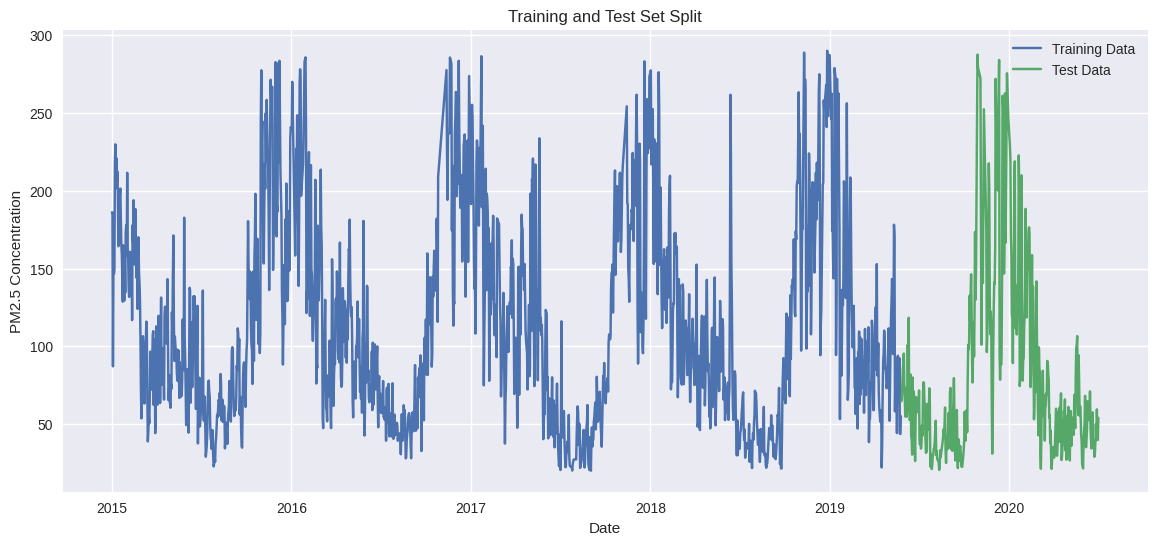

In [8]:
# Splitting into training and test sets
train_size = int(len(cleaned_ts) * 0.8)
train = cleaned_ts.iloc[:train_size]
test = cleaned_ts.iloc[train_size:]

print(f"\nTraining set size: {len(train)}")
print(f"Test set size: {len(test)}")

# Visualize the split
plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.title('Training and Test Set Split')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid(True)
plt.show()


Fitting ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=5.77 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=18050.166, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=15521.498, Time=2.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=16406.499, Time=1.53 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=20313.549, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=15528.089, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=15521.189, Time=4.89 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=15521.451, Time=9.70 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=15519.418, Time=3.44 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=15522.146, Time=1.17 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=15521.431, Time=8.08 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=15521.834, Time=3.34 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=15523.110, Time=9.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.

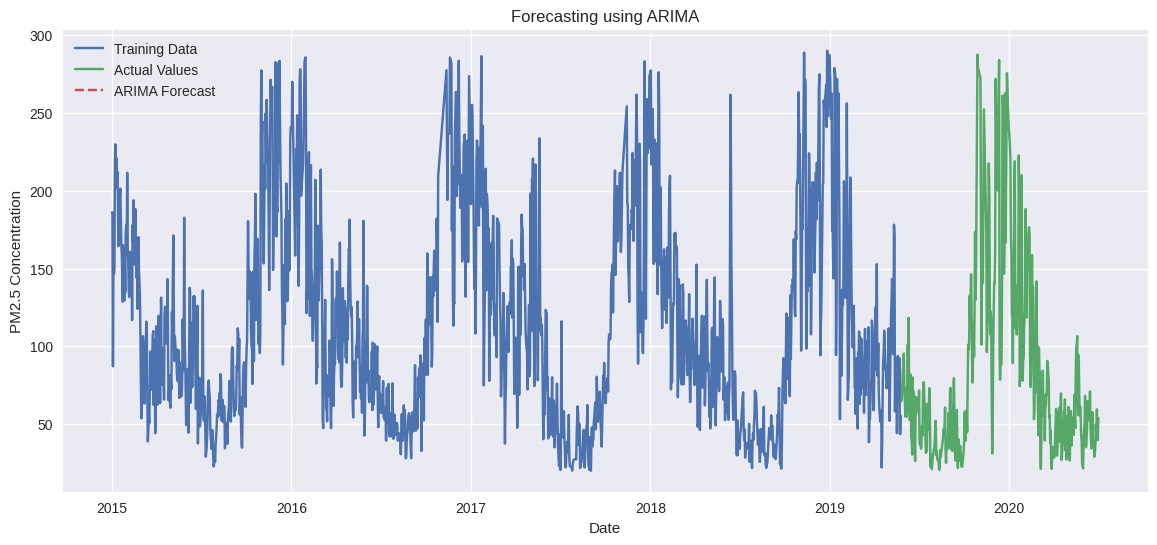

In [9]:
# Forecasting using ARIMA
def arima_forecast(train_data, test_data):
    try:
        print("\nFitting ARIMA model...")
        model = auto_arima(train_data, seasonal=True, m=12,
                           suppress_warnings=True,
                           stepwise=True, trace=True)
        
        print("\nObtained model parameters:")
        print(model.summary())
        
        # Forecast
        forecast = model.predict(n_periods=len(test_data))
        forecast = pd.Series(forecast, index=test_data.index)
        
        # Fill any potential NaN values
        forecast = forecast.fillna(method='ffill').fillna(method='bfill')
        
        return forecast
    
    except Exception as e:
        print(f"\nError building ARIMA model: {str(e)}")
        return None


# Perform ARIMA forecast
arima_pred = arima_forecast(train['PM2.5'], test['PM2.5'])

# Visualize ARIMA results
if arima_pred is not None:
    plt.figure(figsize=(14, 6))
    plt.plot(train['PM2.5'], label='Training Data')
    plt.plot(test['PM2.5'], label='Actual Values')
    plt.plot(arima_pred, label='ARIMA Forecast', linestyle='--')
    plt.title('Forecasting using ARIMA')
    plt.xlabel('Date')
    plt.ylabel('PM2.5 Concentration')
    plt.legend()
    plt.grid(True)
    plt.show()


Training Holt-Winters model...


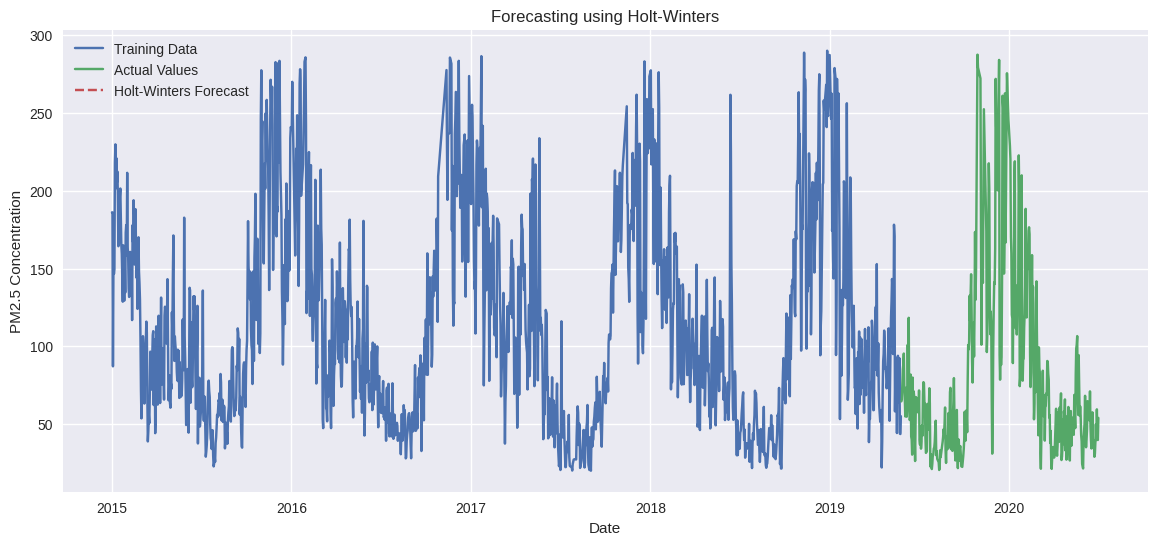

In [10]:
# Forecasting using Holt-Winters
def holt_winters_forecast(train_data, test_data):
    try:
        print("\nTraining Holt-Winters model...")
        model = ExponentialSmoothing(train_data,
                                     seasonal='add',
                                     trend='add',
                                     seasonal_periods=30)
        model_fit = model.fit()
        
        # Forecast
        forecast = model_fit.forecast(len(test_data))
        forecast = pd.Series(forecast, index=test_data.index)
        
        return forecast
    
    except Exception as e:
        print(f"\nError building Holt-Winters model: {str(e)}")
        return None

# Perform Holt-Winters forecast
hw_pred = holt_winters_forecast(train['PM2.5'], test['PM2.5'])

# Visualize Holt-Winters results
if hw_pred is not None:
    plt.figure(figsize=(14, 6))
    plt.plot(train['PM2.5'], label='Training Data')
    plt.plot(test['PM2.5'], label='Actual Values')
    plt.plot(hw_pred, label='Holt-Winters Forecast', linestyle='--')
    plt.title('Forecasting using Holt-Winters')
    plt.xlabel('Date')
    plt.ylabel('PM2.5 Concentration')
    plt.legend()
    plt.grid(True)
    plt.show()


Preparing data for LSTM...


I0000 00:00:1749506317.957578      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Training LSTM model...


I0000 00:00:1749506321.646141      71 service.cc:148] XLA service 0x783394006d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749506321.646742      71 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749506321.929648      71 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749506322.659775      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


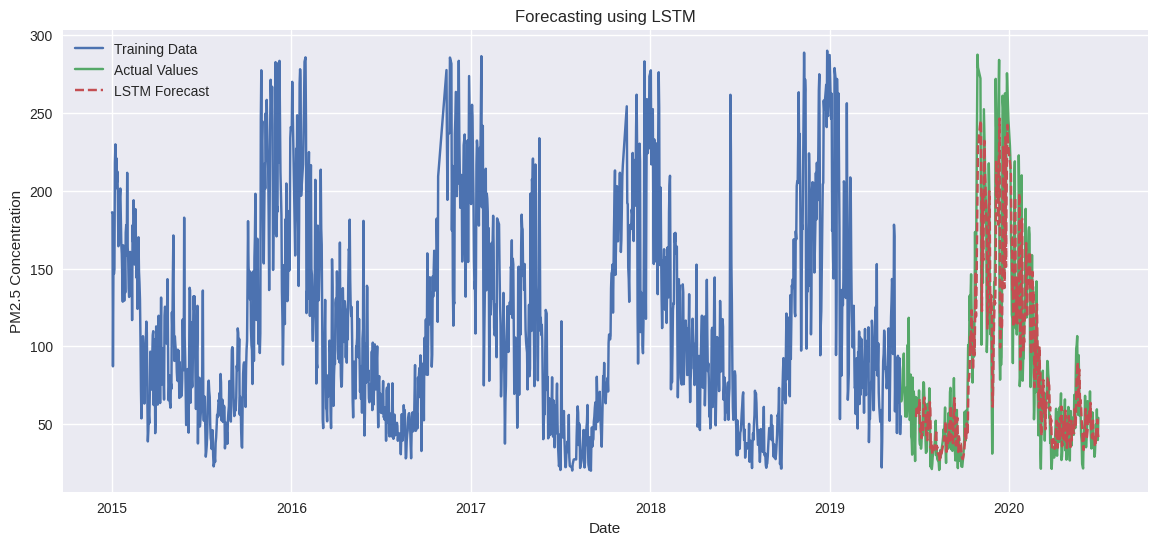

In [11]:
# Forecasting using LSTM
def lstm_forecast(train_data, test_data, n_steps=30, epochs=50):
    try:
        print("\nPreparing data for LSTM...")
        # Normalize data
        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
        test_scaled = scaler.transform(test_data.values.reshape(-1, 1))
        
        # Create sequences
        def create_sequences(data, seq_length):
            X, y = [], []
            for i in range(len(data)-seq_length):
                X.append(data[i:i+seq_length])
                y.append(data[i+seq_length])
            return np.array(X), np.array(y)
        
        X_train, y_train = create_sequences(train_scaled, n_steps)
        X_test, y_test = create_sequences(test_scaled, n_steps)
         
        # Build model
        model = Sequential([
            LSTM(50, activation='relu', input_shape=(n_steps, 1)),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        
        # Train model
        print("\nTraining LSTM model...")
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)
        
        # Forecast
        forecast_scaled = model.predict(X_test, verbose=0)
        forecast = scaler.inverse_transform(forecast_scaled)
        
        # Create forecast time series
        forecast_series = pd.Series(forecast.flatten(), 
                                    index=test_data.index[n_steps:])
        
        return forecast_series
         
    except Exception as e:
        print(f"\nError building LSTM model: {str(e)}")
        return None

# Perform LSTM forecast
lstm_pred = lstm_forecast(train['PM2.5'], test['PM2.5'])

# Visualize LSTM results
if lstm_pred is not None:
    plt.figure(figsize=(14, 6))
    plt.plot(train['PM2.5'], label='Training Data')
    plt.plot(test['PM2.5'], label='Actual Values')
    plt.plot(lstm_pred, label='LSTM Forecast', linestyle='--')
    plt.title('Forecasting using LSTM')
    plt.xlabel('Date')
    plt.ylabel('PM2.5 Concentration')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
# Forecast quality evaluation
def evaluate_forecast(actual, predicted, model_name):
    # Create DataFrame for easier processing
    eval_df = pd.DataFrame({
        'actual': actual,
        'predicted': predicted
    }).dropna()
    
    if len(eval_df) == 0:
        print(f"\n{model_name}: No data for evaluation")
        return
    
    # Calculate metrics
    mae = mean_absolute_error(eval_df['actual'], eval_df['predicted'])
    rmse = np.sqrt(mean_squared_error(eval_df['actual'], eval_df['predicted']))
    
    try:
        mape = np.mean(np.abs((eval_df['actual'] - eval_df['predicted']) / eval_df['actual'])) * 100
    except:
        mape = np.nan
    
    print(f"\nEvaluation results for {model_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    if not np.isnan(mape):
        print(f"MAPE: {mape:.2f}%")
    print(f"Number of points for evaluation: {len(eval_df)}")

# Evaluate models
if arima_pred is not None:
    evaluate_forecast(test['PM2.5'], arima_pred, "ARIMA")

if hw_pred is not None:
    evaluate_forecast(test['PM2.5'], hw_pred, "Holt-Winters")

if lstm_pred is not None:
    evaluate_forecast(test['PM2.5'][len(test)-len(lstm_pred):], lstm_pred, "LSTM")


ARIMA: No data for evaluation

Holt-Winters: No data for evaluation

Evaluation results for LSTM:
MAE: 19.39
RMSE: 28.29
MAPE: 25.27%
Number of points for evaluation: 372


In [13]:
# Conclusions and recommendations

print(" ARIMA usually performs well for stationary series")
print(" To improve results, try:")
print("   - Additional data cleaning")
print("   - Hyperparameter tuning for models")

 ARIMA usually performs well for stationary series
 To improve results, try:
   - Additional data cleaning
   - Hyperparameter tuning for models
